# US-Workshop (2023): ULTRASOUND DOPPLER TECHNIQUES
<hr/>

## EX2: Doppler Processing
* Ultrasound Doppler techniques is used to assess/measure blood flow.
* In this notebook, we process CW (Continuous Wave) Doppler audio signals acquired using SONOMED-Veno apparatus on carotid and radial arteries.
* Spectral analysis (Spectrogram) can reveal many features, which are not visible in time domain at the first sight. Next, the frequency spectrum can be recalculated to real blood velocity values, once the insonification angle is known.
* Finally, a few diagnostically important parameters will be estimated from the velocity spectrogram, such as peak systolic velocity (PSV), end diastolic velocity (EDV), the Resistance Index (RI) and the Pulsatility Index (PI).
* You can use [AUDACITY](https://audacity.pl/) app to play individual recordings.

### TOC
* [Read Doppler WAV file](#read-doppler-wav-file)
* [Analyze data in frequnecy domain](#analyze-data-in-frequnecy-domain)
* [Visualize data](#visualize-data)
* [Function calculating velocity from Doppler frequencies](#function-calculating-velocity-from-doppler-frequencies)
* [Construction of velocity spectrogram](#construction-of-velocity-spectrogram)
* [Envelope detection](#envelope-detection)
* [Locations of PSV and EDV](#locations-of-psv-and-edv)
* [Blood flow parameters estimation](#blood-flow-parameters-estimation)

### LINKS
1. [H.Torp, Signal processing in Ultrasound Doppler and Color Flow Imaging](https://folk.ntnu.no/htorp/Undervisning/FlowMeas02/papers/EstBloodVel.pdf)
2. [F.S.Schlindwein et al., Real-time digital processing of Doppler ultrasound signals and calculation of flow parameters](https://www.researchgate.net/profile/Fernando-Schlindwein/publication/15230110_Real-time_digital_processing_of_Doppler_ultrasound_signals_and_calculation_of_flow_parameters/links/54f031e90cf25f74d7241b4f/Real-time-digital-processing-of-Doppler-ultrasound-signals-and-calculation-of-flow-parameters.pdf)
3. [C.Deane, Doppler in Obstetrics in "Doppler in Obstetrics" by K.Nicolaides, G.Rizzo, K.Hecher](https://fetalmedicine.org/var/uploads/web/Doppler/Doppler%20Ultrasound%20-%20Principles%20and%20practice.pdf)

[![Lab4US](../figs/Lab4US-banner-EN-800.png)](https://lab4us.eu)
<hr/>

In [ ]:
# ! git clone https://github.com/Lab4US/2023-us-workshop-fuw

# %cd /content/2023-us-workshop-fuw/data/ex2-doppler/

# from google.colab import files
# uploaded = files.upload()
# if uploaded:
#   print("success")

# %cd /content/2023-us-workshop-fuw/notebooks/

In [10]:
import os.path
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.fft import fft, fftfreq, ifft
from scipy.io.wavfile import read as read_wav
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, find_peaks, find_peaks_cwt
from extern_functions import hl_envelopes_idx, get_envelope

In [2]:
#%% CONSTS
DATA_PATH = r'../data/ex2-doppler'  # our example data folder

T_RANGE = 70        # time scale range [s]
F_RANGE = 2000      # freq range [Hz]
filt_freq_lower = 15  # [Hz]
filt_freq_upper = 2000  # [Hz]

### Read Doppler WAV file

In [3]:
#%% READ CW DOPPLER AUDIO FILES
AUDIO_FS, data = read_wav(os.path.join(DATA_PATH, "person1-cw-RA.wav"))
# AUDIO_FS, data = read_wav(os.path.join(DATA_PATH, "person1-cw-cca.wav"))  # enter your filename

doppler = data[:, 0]  # choose one channel if stereo file

N = len(doppler)
T = 1/AUDIO_FS
dop_time = np.linspace(0, N*T, len(doppler))

### Analyze data in frequnecy domain

In [4]:
#%% APPLY FFT - SPECTRAL PROCESSING
fft_dop = fft(doppler)
freqs_dop = fftfreq(N, T)
i_sorted = np.argsort(freqs_dop)
ps = np.abs(fft_dop)**2  # calculate spectrum power

# (optional) High-pass filter in frequnecy domain - aka "wall filter" to remove probe movement signal
cut_f_signal = fft_dop.copy()
cut_f_signal[(freqs_dop < filt_freq_lower)] = 0    # HP filter
cut_signal = ifft(cut_f_signal)

### Visualize data

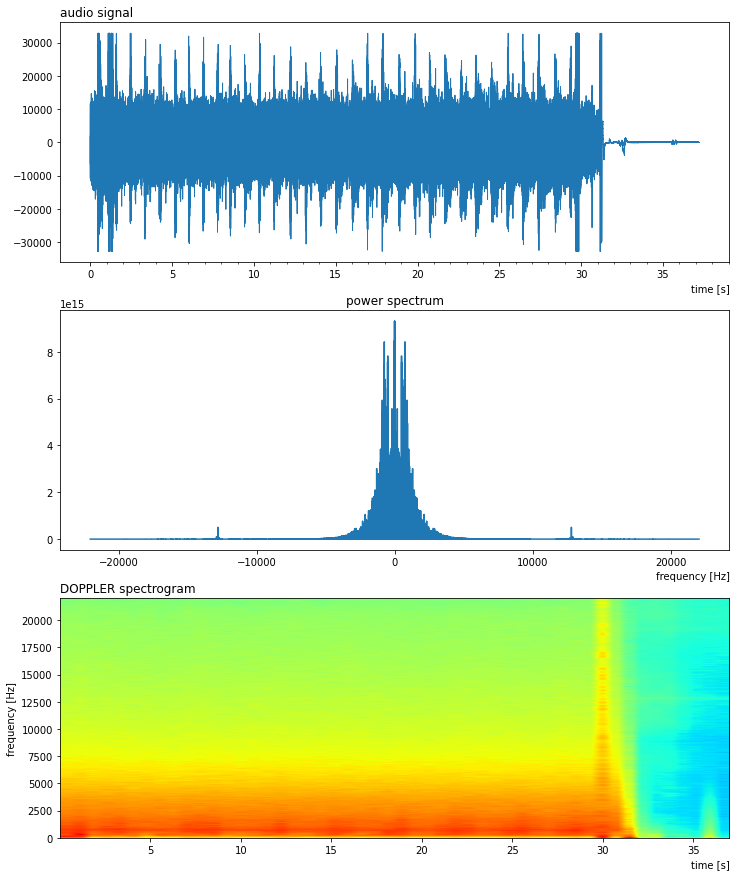

In [6]:
#%% PLOT DOPPLER SINGAL, POWER, SPECTROGRAM

fig, axs = plt.subplots(3, figsize=(12, 15))

# Plot RAW SIGNAL in time domain
axs[0].set_title('audio signal', loc='left')
axs[0].set_xlabel('time [s]', loc='right')
# axs[0].set_ylabel('...')
axs[0].set_xticks(range(0, T_RANGE), minor=True)
axs[0].plot(dop_time, doppler, linewidth=1, linestyle="-")

# Plot POWER SPECTRUM (one-sided)
axs[1].set_title('power spectrum', loc='center')
axs[1].set_xlabel('frequency [Hz]', loc='right')
# axs[1].set_xlim(0, F_RANGE)
axs[1].plot(freqs_dop[i_sorted], ps[i_sorted])

# Plot SPECTROGRAM
axs[2].set_title('DOPPLER spectrogram', loc='left')
axs[2].set_xlabel('time [s]', loc='right')
axs[2].set_ylabel('frequency [Hz]')
NFFT = 1024*32
# (Pxx, freqs, bins, im) = axs[2].specgram(doppler, NFFT=NFFT, Fs=AUDIO_FS, noverlap=int(NFFT*.5), scale='dB', cmap="jet")
(Pxx, freqs, bins, im) = axs[2].specgram(
    doppler, NFFT=NFFT, Fs=AUDIO_FS, noverlap=None, scale='dB', cmap="jet")

plt.show()

##### What is the difference with and without overlapping? 


### Function to convert Doppler frequency to velocity

In [7]:
speed_of_sound = 1540   # [m/s]
theta = 0               # angle correction [rad]
f0 = 8e6                # ultrasound trasmit frequency [Hz]

def convert_to_velo(f):
    return 100*speed_of_sound*f/(2*f0*math.cos(theta))  # [cm/s]

### Velocity spectrogram

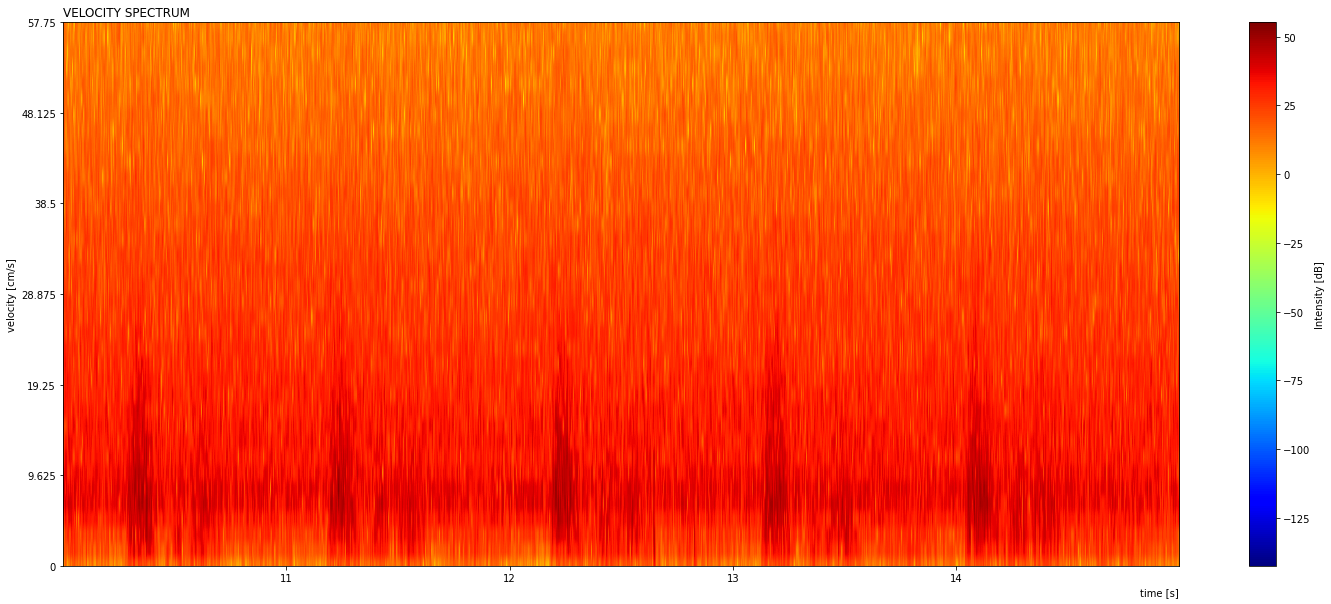

In [8]:
#%% PLOT VELOCITY SPECTRUM for selected 5 sec of signal
from_sec = 10

fig, axs = plt.subplots(figsize=(25, 10))
axs.set_title('VELOCITY SPECTRUM', loc='left')
axs.set_xlabel('time [s]', loc='right')
axs.set_ylabel('velocity [cm/s]')
Pxx, freqs, bins, cax = axs.specgram(
    cut_signal[from_sec*AUDIO_FS:(from_sec+5)*AUDIO_FS], Fs=AUDIO_FS, noverlap=None, scale='dB', cmap='jet', mode='psd')
axs.set_ylim(0, 3*F_RANGE)

ticks_y = ticker.FuncFormatter(
    lambda x, pos: '{0:g}'.format(convert_to_velo(x)))
axs.yaxis.set_major_formatter(ticks_y)

ticks_x = ticker.FuncFormatter(
    lambda x, pos: '{0:g}'.format(x+from_sec))
axs.xaxis.set_major_formatter(ticks_x)

fig.colorbar(cax).set_label('Intensity [dB]')

### Envelop detection

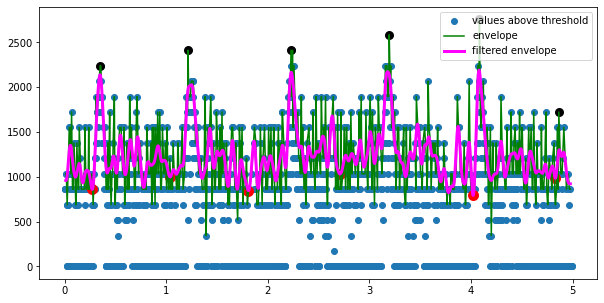

In [17]:
#%% ENVELOP DETECTION

A, B = Pxx.shape
ardB = 10*np.log10((Pxx[round(A/2):, :]))   # convert power values to dB scale
threshold = 39  # in dB

# find the highest frequency (or velocity) in every timestamp with value above threshold
vec_th = np.zeros(B)
for i in range(B):
    try:
        maxiIx = np.where(ardB[:, i] > threshold)[0][-1]
    except:
        maxiIx = 0
    vi = maxiIx + round(A/2)
    vec_th[i] = freqs[vi]

fig, axs = plt.subplots(figsize=(10, 5))
axs.scatter(bins, vec_th, label='values above threshold')

# detect ENVELOP from previously found values (with external function)
_, lmax = hl_envelopes_idx(vec_th.copy())
axs.plot(bins[lmax], vec_th[lmax], 'green', label='envelope')
env_time1 = bins[lmax]
env_val1 = vec_th[lmax]

# ENVELOP's interpolation
f1 = interp1d(env_time1, env_val1)
env_time_inter = np.arange(env_time1[0], env_time1[-1], T)
env_val_inter = f1(env_time_inter)

# ENVELOP's filtration
b, a = butter(3, 2*15/AUDIO_FS, btype='low', analog=False)
output = filtfilt(b, a, env_val_inter.copy())
axs.plot(env_time_inter, output, 'magenta',
         linewidth=3, label='filtered envelope')

# minimal distance in samples between searched peaks = max 100 bpm
dist = round(0.6*AUDIO_FS)

# searching for PSV points
peaks, _ = find_peaks(env_val_inter, distance=dist)
axs.scatter(env_time_inter[peaks],
            env_val_inter[peaks], color='black', linewidth=3)

# searching for EDV points
minimas, _ = find_peaks(-output, distance=dist)
tmp = []
for m in minimas:
    [tmp.append(m) for p in peaks if (m < p) and (m > p-0.5*AUDIO_FS)]

minimas = tmp
axs.scatter(env_time_inter[minimas], output[minimas], color='red', linewidth=5)
axs.legend(loc='best')

### Locations of PSV and EDV

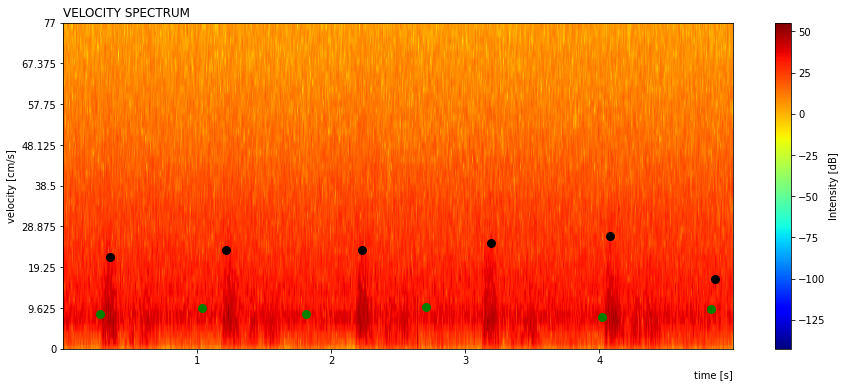

In [18]:
#%% PLOT VELOCITY SPECTRUM with POINTS

fig, axs = plt.subplots(figsize=(15, 6))
axs.set_title('VELOCITY SPECTRUM', loc='left')
axs.set_xlabel('time [s]', loc='right')
axs.set_ylabel('velocity [cm/s]')
_, _, _, cax = axs.specgram(
    cut_signal[from_sec*AUDIO_FS:(from_sec+5)*AUDIO_FS], Fs=AUDIO_FS, noverlap=None, scale='dB', cmap='jet', mode='psd')
axs.set_ylim(0, 4*F_RANGE)

# plot PSV points
axs.scatter(env_time_inter[peaks],
            env_val_inter[peaks], color='black', linewidth=3)

# plot EDV points
axs.scatter(env_time_inter[minimas],
            output[minimas], color='green', linewidth=3)

ticks_y = ticker.FuncFormatter(
    lambda x, pos: '{0:g}'.format(convert_to_velo(x)))
axs.yaxis.set_major_formatter(ticks_y)

fig.colorbar(cax).set_label('Intensity [dB]')

### Calculate selected blood flow parameters

In [20]:
data = env_val1.copy()

# Calc mean velocity (MV)
data[data == 0] = np.nan
MV = np.nanmean(convert_to_velo(data))
print('MV ', np.round(MV, 2), ' [cm/s]')

# Calc peak-systolic velocity (PSV)
PSV = np.mean(convert_to_velo(env_val_inter[peaks]))
print('PSV ', np.round(PSV, 2), ' [cm/s]')

# Calc end-diastolic velocity (EDV)
EDV = np.mean(convert_to_velo(output[minimas]))
print('EDV ', np.round(EDV, 2), ' [cm/s]')

# Calc the Resistance Index (RI)
RI = (PSV-EDV)/PSV
print('\nRI ', np.round(RI, 2))
# normal range of RI is 0.5-0.7 (in both CCA and RA)

# Calc the Pulsatility Index (PI)
PI = (PSV-EDV)/MV
print('\nPI ', np.round(PI, 2))
# normal range of PI is <1.5 for CCA and RA

MV  11.75  [cm/s]
PSV  22.66  [cm/s]
EDV  8.84  [cm/s]

RI  0.61

PI  1.18
